In [31]:
!pip install --upgrade imbalanced-learn
!pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier


from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import time

In [33]:
# 1. Dataview

In [34]:
df = pd.read_csv('./data/train.csv')
df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [36]:
df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,0.018887,-0.029860,0.192931,-0.097563,0.064948,0.082161,0.133121,-0.007633,0.041929,-0.050953,-0.019295,0.030951,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,1.152284,1.096870,1.047129,1.143030,1.048403,0.978313,0.950533,0.882970,0.912961,0.834891,0.812640,0.725834,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.049895,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-22.838548,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,-0.660083,-0.519237,-0.565404,-0.509487,-0.626833,-0.336870,-0.449761,-0.470979,-0.417753,-0.524206,-0.497651,-0.183583,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,-0.078963,-0.111448,0.119980,0.110904,0.031907,0.093021,0.244211,0.063845,-0.018106,-0.052349,-0.022296,-0.036160,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,0.641358,0.408345,0.999152,0.617389,0.743255,0.528002,0.828286,0.527882,0.435482,0.432105,0.467626,0.155777,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.784514,6.098529,9.253526,5.041069,5.228342,39.420904,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [37]:
# 최대 열 출력 수를 늘림
pd.set_option('display.max_columns', None)

df.filter(like='V').describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,0.018887,-0.029860,0.192931,-0.097563,0.064948,0.082161,0.133121,-0.007633,0.041929,-0.050953,-0.019295,0.030951,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445
std,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,1.152284,1.096870,1.047129,1.143030,1.048403,0.978313,0.950533,0.882970,0.912961,0.834891,0.812640,0.725834,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315
min,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.049895,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-22.838548,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896
25%,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,-0.660083,-0.519237,-0.565404,-0.509487,-0.626833,-0.336870,-0.449761,-0.470979,-0.417753,-0.524206,-0.497651,-0.183583,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054
50%,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,-0.078963,-0.111448,0.119980,0.110904,0.031907,0.093021,0.244211,0.063845,-0.018106,-0.052349,-0.022296,-0.036160,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152
75%,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,0.641358,0.408345,0.999152,0.617389,0.743255,0.528002,0.828286,0.527882,0.435482,0.432105,0.467626,0.155777,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302
max,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.784514,6.098529,9.253526,5.041069,5.228342,39.420904,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808


In [38]:
df.columns

Index(['id', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [39]:
df['Class'].value_counts(normalize=True)

Class
0    0.997893
1    0.002107
Name: proportion, dtype: float64

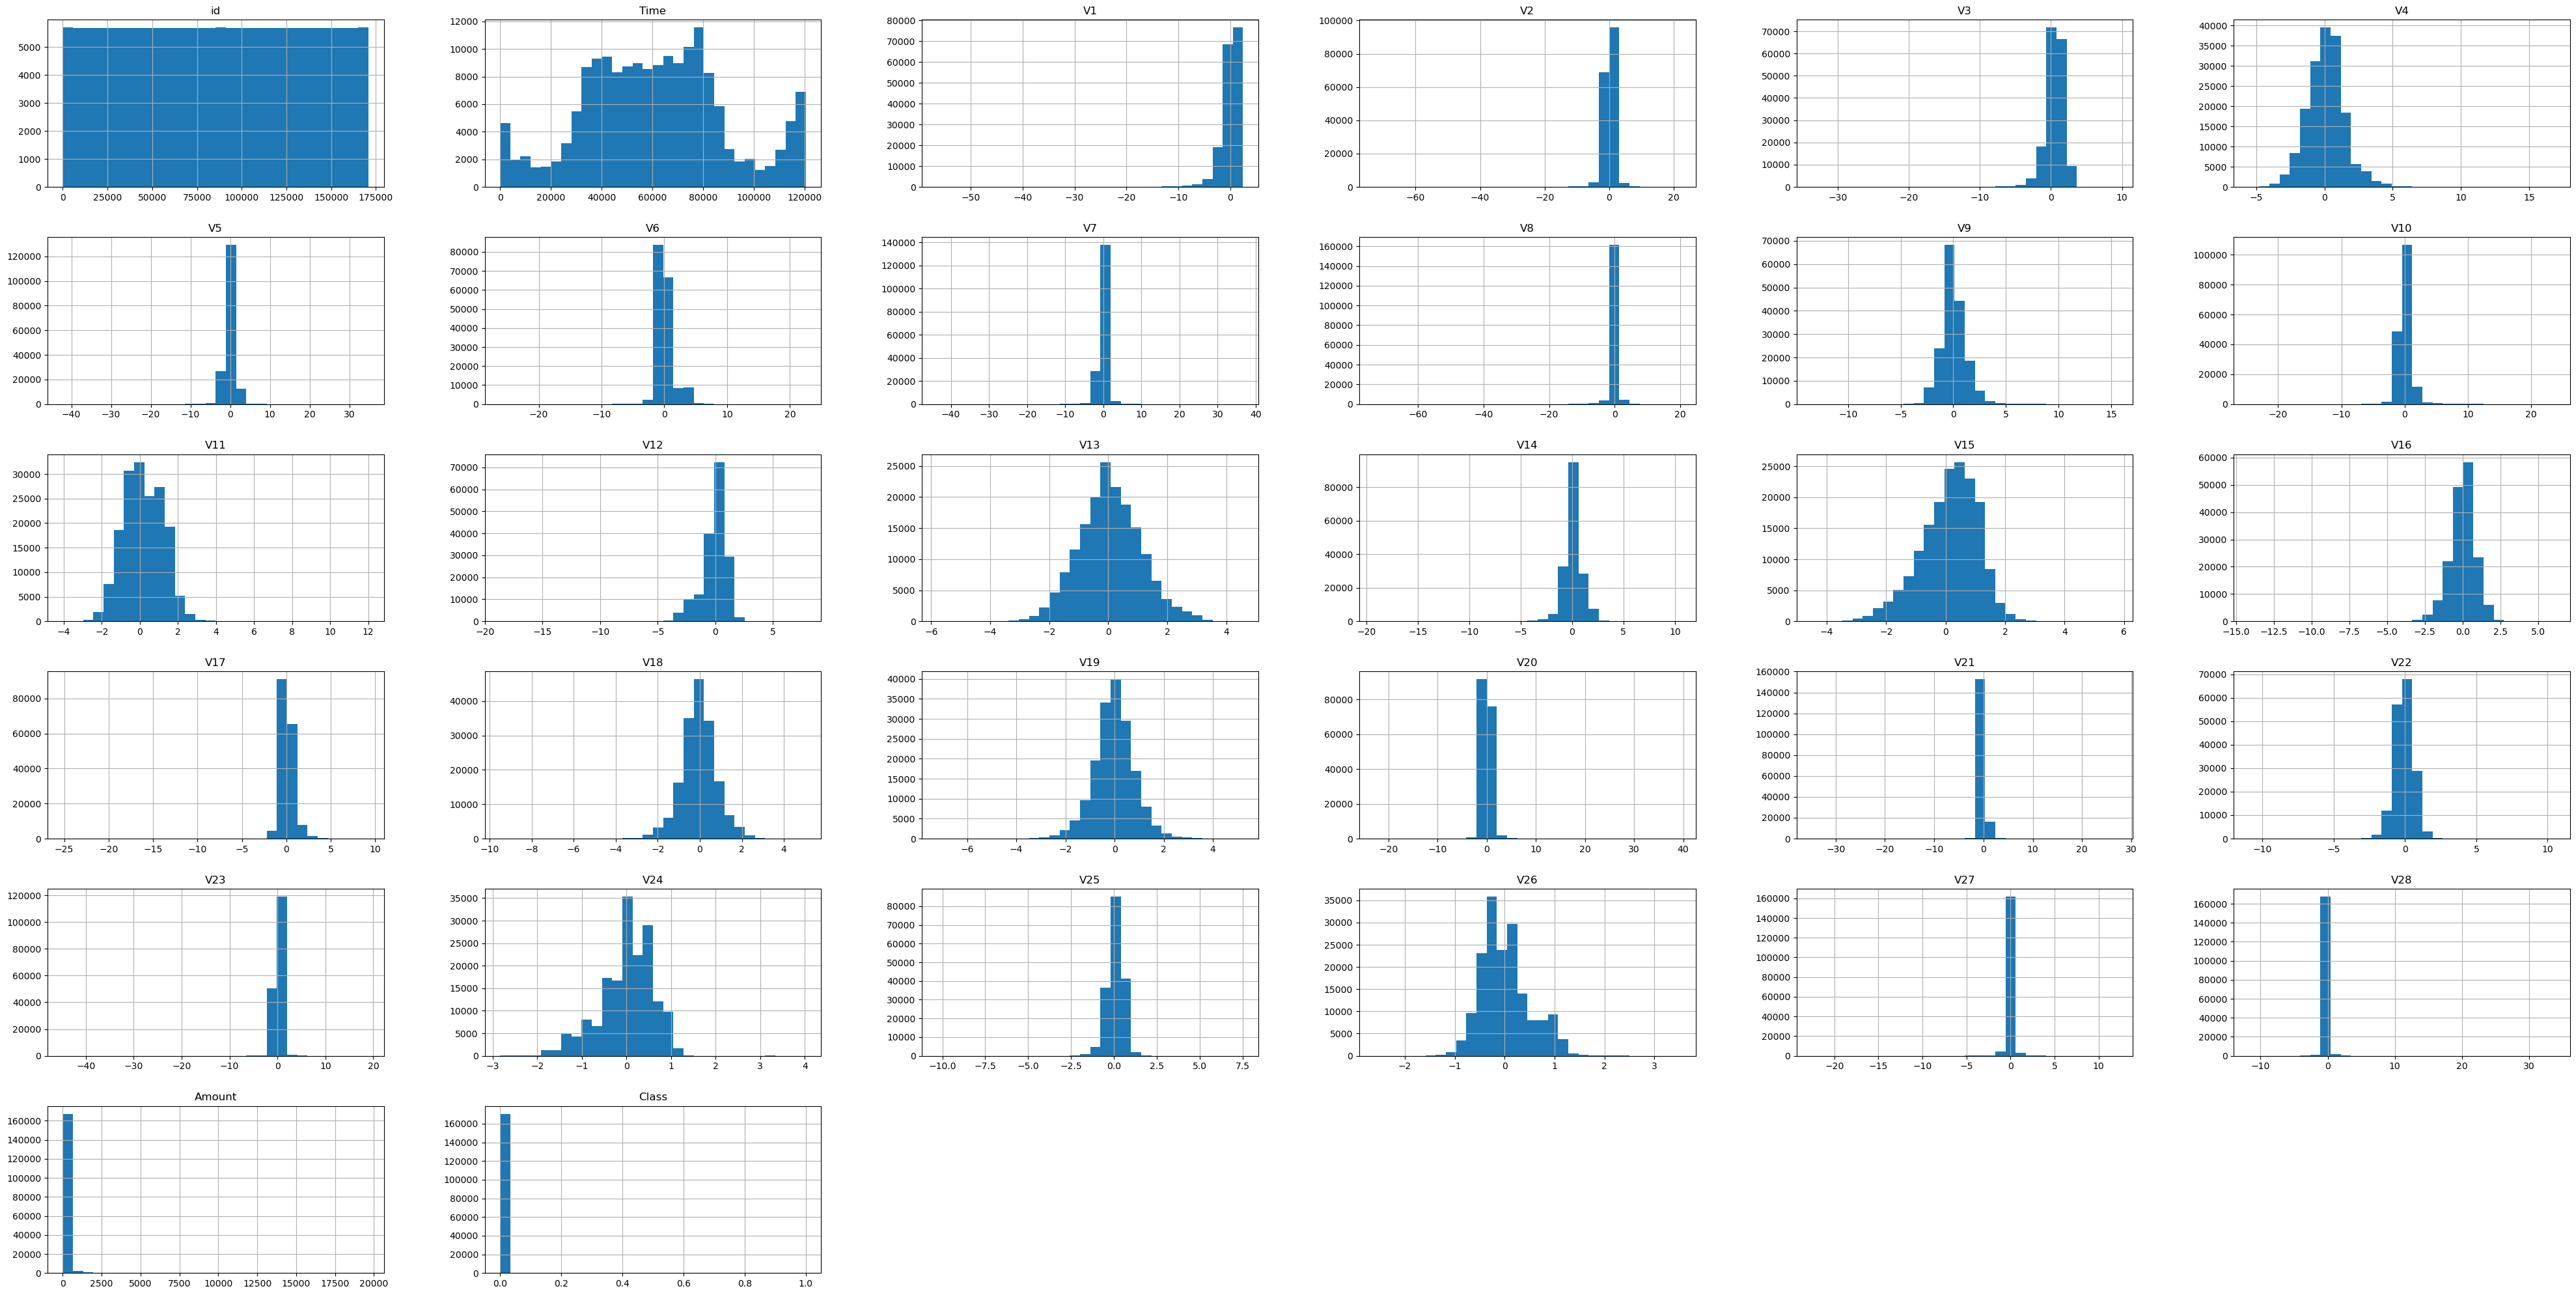

In [40]:
df.hist(bins=30, figsize=(50, 25))

plt.show()

In [41]:
# 2. 데이터 분할 및 교차검증
# StratifiedKFold, Lgbm 모델로 교차검증 (amount 칼럼에만 스케일링 적용)
# 데이터 분할을 교차검증으로 stratifiedkfold로 진행하고 lgbm 모델로 성능평가하고, 이후에 스케일링을 amount 칼럼만 진행해서 데이터 리킹 없이 진행
# 스케일링 이후에 smote 진행행

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate

numeric_features = ['Amount'] 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough' 
)

# 스케일링 -> SMOTE 오버샘플링 -> LGBM 모델
pipeline = Pipeline([
    ('preprocessor', preprocessor),   
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)), 
    ('classifier', LGBMClassifier())
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['precision', 'recall', 'f1', 'average_precision']
scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


print("Cross-Validation Results:")
for metric in scoring:
    print(f"{metric.capitalize()} Scores:", scores[f'test_{metric}'])
    print(f"Mean {metric.capitalize()}:", scores[f'test_{metric}'].mean())

[LightGBM] [Info] Number of positive: 136418, number of negative: 136418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 272836, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 136418, number of negative: 136418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 272836, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 136418, number of negative: 136418
[LightGBM] [Info] Auto-choosing col-wise mu

In [ ]:
# 성능 지표 공부 - 어떤 성능지표와 시각화 도구 -> 해석하는데 용이하게/ 매치 시켜서 생각하는게 아님 "(ex 혼동행렬은 다른거 같음)"
# smote를 적용한 데이터에서 각각의 성능 지표를 모델에 적용시킬때 유의점 파악 (ex. 훈련데이터에서만 적용되는 것임, 따라서 교차검증을 통해 검증데이터에서는 적용이 안되는거..?) -> 이건 스모트 내부에서 작용 
# -> smote 작동원리 공부!!



[LightGBM] [Info] Number of positive: 170523, number of negative: 170523
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 341046, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


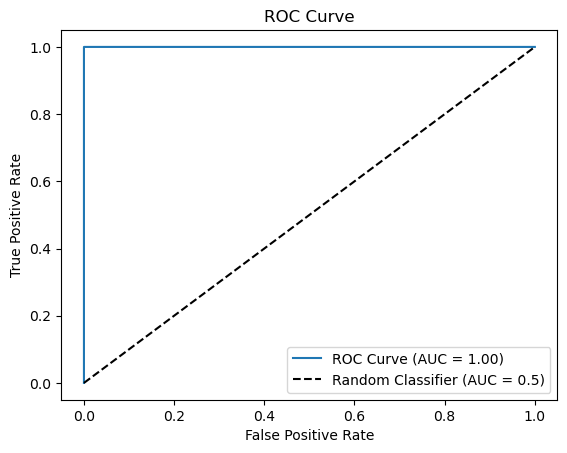

In [49]:
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split

# 전체 데이터로 최종 모델 학습
pipeline.fit(X, y)

# 테스트 데이터 분할 (예시용으로 전체 데이터를 훈련 후 테스트 세트로 분할하여 평가)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 최종 모델로 예측 확률 계산
y_prob = pipeline.predict_proba(X_test)[:, 1]

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# ROC Curve 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Precision-Recall Curve

# 설명: Precision-Recall Curve는 다양한 임곗값에서 **Precision(정밀도)**과 **Recall(재현율)**의 관계를 시각화한 그래프입니다.
# 용도: 특히 불균형 데이터셋에서 모델의 성능을 평가하는 데 유용합니다. Precision이 높을수록 양성 예측의 정확도가 높고, Recall이 높을수록 실제 양성을 잘 찾아냅니다.
# AUC-PR: 그래프 아래 면적(AUC)을 계산해 성능을 수치로 나타낼 수 있습니다. 

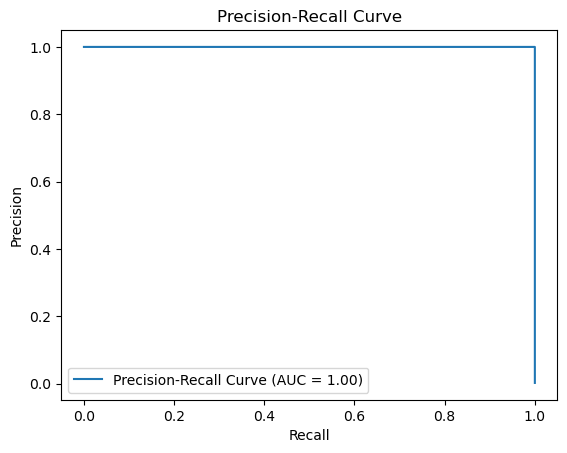

In [50]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
# Confusion Matrix (혼동 행렬)

# 설명: Confusion Matrix는 모델의 예측 결과를 TP (True Positive), FP (False Positive), FN (False Negative), **TN (True Negative)**으로 나타낸 표입니다.
# 용도: 모델의 예측 결과를 자세히 분석할 수 있어, 특정 오류(예: 1종 오류와 2종 오류)를 줄이는 데 유용합니다.
# 시각화: heatmap으로 시각화하여 직관적으로 오류 분포를 파악할 수 있습니다.

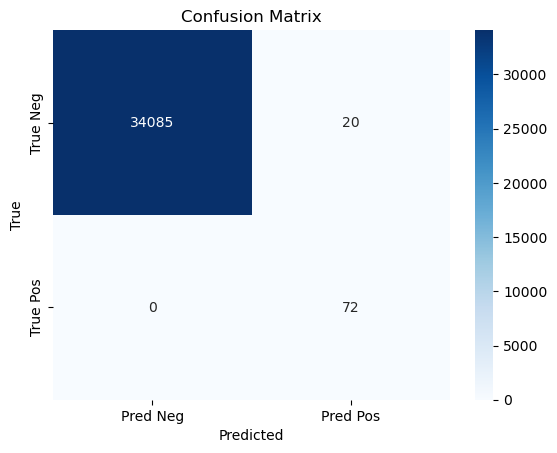

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Cross-Validation Results:
# Precision Scores: [0.67741935 0.73626374 0.81081081 0.67021277 0.6744186 ]
# Mean Precision: 0.7138250545043733

# Recall Scores: [0.875      0.93055556 0.83333333 0.875      0.80555556]
# Mean Recall: 0.8638888888888889

# F1 Scores: [0.76363636 0.82208589 0.82191781 0.75903614 0.73417722]
# Mean F1: 0.7801706842388562

# Average_precision Scores: [0.83686128 0.91986044 0.81887023 0.78667227 0.80993289]
# Mean Average_precision: 0.8344394228496679

In [ ]:
# 이상치 처리 진행 안함

# import matplotlib.pyplot as plt

# for column in df.select_dtypes(include='number').columns:
#     plt.figure(figsize=(10, 6))
#     plt.boxplot(df[column])
#     plt.title(f'Boxplot of {column}')
#     plt.xlabel(column)
#     plt.show()
